In [1]:
import os, sys
import numpy as np
import shutil
from tqdm import tqdm
import time
import torch
from PIL import Image
import logging
import os.path as osp
from hydra import initialize, compose
# set level logging
logging.basicConfig(level=logging.INFO)
import logging
import trimesh
import numpy as np
from hydra.utils import instantiate
import argparse
import glob
from omegaconf import DictConfig, OmegaConf
from torchvision.utils import save_image
import torchvision.transforms as T
import cv2
import imageio
import distinctipy
from skimage.feature import canny
from skimage.morphology import binary_dilation
from segment_anything.utils.amg import rle_to_mask

In [2]:
sys.path.append('/code/SAM-6D/Instance_Segmentation_Model')

In [3]:
from utils.poses.pose_utils import get_obj_poses_from_template_level, load_index_level_in_level2
from utils.bbox_utils import CropResizePad
from model.utils import Detections, convert_npz_to_json
from model.loss import Similarity
from utils.inout import load_json, save_json_bop23

In [4]:
inv_rgb_transform = T.Compose(
        [
            T.Normalize(
                mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
            ),
        ]
    )

In [5]:
def visualize(rgb, detections, save_path="tmp.png"):
    img = rgb.copy()
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    colors = distinctipy.get_colors(len(detections))
    alpha = 0.33

    best_score = 0.
    for mask_idx, det in enumerate(detections):
        if best_score < det['score']:
            best_score = det['score']
            best_det = detections[mask_idx]

    mask = rle_to_mask(best_det["segmentation"])
    edge = canny(mask)
    edge = binary_dilation(edge, np.ones((2, 2)))
    obj_id = best_det["category_id"]
    temp_id = obj_id - 1

    r = int(255*colors[temp_id][0])
    g = int(255*colors[temp_id][1])
    b = int(255*colors[temp_id][2])
    img[mask, 0] = alpha*r + (1 - alpha)*img[mask, 0]
    img[mask, 1] = alpha*g + (1 - alpha)*img[mask, 1]
    img[mask, 2] = alpha*b + (1 - alpha)*img[mask, 2]   
    img[edge, :] = 255
    
    img = Image.fromarray(np.uint8(img))
    img.save(save_path)
    prediction = Image.open(save_path)
    
    # concat side by side in PIL
    img = np.array(img)
    concat = Image.new('RGB', (img.shape[1] + prediction.size[0], img.shape[0]))
    concat.paste(rgb, (0, 0))
    concat.paste(prediction, (img.shape[1], 0))
    return concat

In [6]:
def batch_input_data(depth_path, cam_path, device):
    batch = {}
    cam_info = load_json(cam_path)
    depth = np.array(imageio.imread(depth_path)).astype(np.int32)
    cam_K = np.array(cam_info['cam_K']).reshape((3, 3))
    depth_scale = np.array(cam_info['depth_scale'])

    batch["depth"] = torch.from_numpy(depth).unsqueeze(0).to(device)
    batch["cam_intrinsic"] = torch.from_numpy(cam_K).unsqueeze(0).to(device)
    batch['depth_scale'] = torch.from_numpy(depth_scale).unsqueeze(0).to(device)
    return batch

In [7]:
def run_inference(segmentor_model, output_dir, cad_path, rgb_path, depth_path, cam_path, stability_score_thresh):
    with initialize(version_base=None, config_path="../code/SAM-6D/Instance_Segmentation_Model/configs"):
        cfg = compose(config_name='run_inference.yaml')

    if segmentor_model == "sam":
        with initialize(version_base=None, config_path="../code/SAM-6D/Instance_Segmentation_Model/configs/model"):
            cfg.model = compose(config_name='ISM_sam.yaml')
        cfg.model.segmentor_model.stability_score_thresh = stability_score_thresh
    elif segmentor_model == "fastsam":
        with initialize(version_base=None, config_path="../code/SAM-6D/Instance_Segmentation_Model/configs/model"):
            cfg.model = compose(config_name='ISM_fastsam.yaml')
    else:
        raise ValueError("The segmentor_model {} is not supported now!".format(segmentor_model))

    logging.info("Initializing model")
    model = instantiate(cfg.model)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.descriptor_model.model = model.descriptor_model.model.to(device)
    model.descriptor_model.model.device = device
    # if there is predictor in the model, move it to device
    if hasattr(model.segmentor_model, "predictor"):
        model.segmentor_model.predictor.model = (
            model.segmentor_model.predictor.model.to(device)
        )
    else:
        model.segmentor_model.model.setup_model(device=device, verbose=True)
    logging.info(f"Moving models to {device} done!")
        
    logging.info("Initializing template")
    template_dir = os.path.join(output_dir, 'templates')
    num_templates = len(glob.glob(f"{template_dir}/*.npy"))
    boxes, masks, templates = [], [], []
    for idx in range(num_templates):
        image = Image.open(os.path.join(template_dir, 'rgb_'+str(idx)+'.png'))
        mask = Image.open(os.path.join(template_dir, 'mask_'+str(idx)+'.png'))
        boxes.append(mask.getbbox())

        image = torch.from_numpy(np.array(image.convert("RGB")) / 255).float()
        mask = torch.from_numpy(np.array(mask.convert("L")) / 255).float()
        image = image * mask[:, :, None]
        templates.append(image)
        masks.append(mask.unsqueeze(-1))
        
    templates = torch.stack(templates).permute(0, 3, 1, 2)
    masks = torch.stack(masks).permute(0, 3, 1, 2)
    boxes = torch.tensor(np.array(boxes))
    
    processing_config = OmegaConf.create(
        {
            "image_size": 224,
        }
    )
    proposal_processor = CropResizePad(processing_config.image_size)
    templates = proposal_processor(images=templates, boxes=boxes).to(device)
    masks_cropped = proposal_processor(images=masks, boxes=boxes).to(device)

    model.ref_data = {}
    model.ref_data["descriptors"] = model.descriptor_model.compute_features(
                    templates, token_name="x_norm_clstoken"
                ).unsqueeze(0).data
    model.ref_data["appe_descriptors"] = model.descriptor_model.compute_masked_patch_feature(
                    templates, masks_cropped[:, 0, :, :]
                ).unsqueeze(0).data
    
    # run inference
    rgb = Image.open(rgb_path).convert("RGB")
    detections = model.segmentor_model.generate_masks(np.array(rgb))
    detections = Detections(detections)
    query_decriptors, query_appe_descriptors = model.descriptor_model.forward(np.array(rgb), detections)

    # matching descriptors
    (
        idx_selected_proposals,
        pred_idx_objects,
        semantic_score,
        best_template,
    ) = model.compute_semantic_score(query_decriptors)

    # update detections
    detections.filter(idx_selected_proposals)
    query_appe_descriptors = query_appe_descriptors[idx_selected_proposals, :]

    # compute the appearance score
    appe_scores, ref_aux_descriptor= model.compute_appearance_score(best_template, pred_idx_objects, query_appe_descriptors)

    # compute the geometric score
    batch = batch_input_data(depth_path, cam_path, device)
    template_poses = get_obj_poses_from_template_level(level=2, pose_distribution="all")
    template_poses[:, :3, 3] *= 0.4
    poses = torch.tensor(template_poses).to(torch.float32).to(device)
    model.ref_data["poses"] =  poses[load_index_level_in_level2(0, "all"), :, :]

    mesh = trimesh.load_mesh(cad_path)
    model_points = mesh.sample(2048).astype(np.float32) / 1000.0
    model.ref_data["pointcloud"] = torch.tensor(model_points).unsqueeze(0).data.to(device)
    
    image_uv = model.project_template_to_image(best_template, pred_idx_objects, batch, detections.masks)

    geometric_score, visible_ratio = model.compute_geometric_score(
        image_uv, detections, query_appe_descriptors, ref_aux_descriptor, visible_thred=model.visible_thred
        )

    # final score
    final_score = (semantic_score + appe_scores + geometric_score*visible_ratio) / (1 + 1 + visible_ratio)

    detections.add_attribute("scores", final_score)
    detections.add_attribute("object_ids", torch.zeros_like(final_score))   
         
    detections.to_numpy()
    save_path = f"{output_dir}/sam6d_results/detection_ism"
    detections.save_to_file(0, 0, 0, save_path, "Custom", return_results=False)
    detections = convert_npz_to_json(idx=0, list_npz_paths=[save_path+".npz"])
    save_json_bop23(save_path+".json", detections)
    vis_img = visualize(rgb, detections, f"{output_dir}/sam6d_results/vis_ism.png")
    vis_img.save(f"{output_dir}/sam6d_results/vis_ism.png")

In [8]:
segmentor_model = 'sam'
output_dir = '/Workspace/Data/Example_ycbv/outputs'
cad_path = '/Workspace/Data/Example_ycbv/obj_000015.ply'
rgb_path = '/Workspace/Data/Example_ycbv/rgb.png'
depth_path = '/Workspace/Data/Example_ycbv/depth.png'
cam_path = '/Workspace/Data/Example_ycbv/camera.json'
stability_score_thresh = 0.97

In [9]:
os.makedirs(f"{output_dir}/sam6d_results", exist_ok=True)
os.chdir('/code/SAM-6D/Instance_Segmentation_Model')

In [10]:
run_inference(segmentor_model, output_dir, cad_path, rgb_path, depth_path, cam_path, 
        stability_score_thresh,
    )

/opt/conda/envs/sam6d/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'ISM_sam.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
INFO:root:Initializing model
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpc9d5to7k
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpc9d5to7k/_remote_module_non_scriptable.py
INFO:root:Loading SAM model from ./checkpoints/segment-anything/
INFO:root:Init CustomSamAutomaticMaskGenerator done!
INFO:dinov2:using MLP layer as FFN
INFO:root:Init CustomDINOv2 done!
INFO:root:Init CustomDINOv2 with full size=640 and proposal size=224 done!
INFO:root:Init CNOS done!
INFO:root:Moving models to cuda done!
INFO:root:Initializing template
/tmp/ipykernel_1694/607080289.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

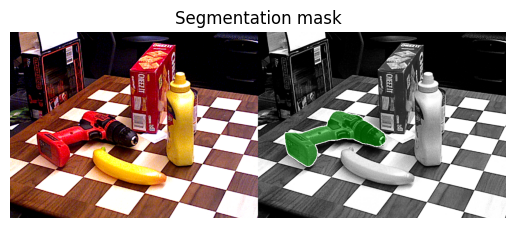

In [12]:
image_path = '/Workspace/Data/Example_ycbv/outputs/sam6d_results/vis_ism.png'
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.title("Segmentation mask")
plt.show()